In [1]:
# !pip install scikit-image

In [2]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

# Set paths
TRAIN_PATH = 'data/train/images/'
MASK_PATH = 'data/train/masks/'

# Load data
train_ids = next(os.walk(TRAIN_PATH))[2]
mask_ids = next(os.walk(MASK_PATH))[2]

# Set parameters
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 3

# Preprocess images
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

for n, id_ in enumerate(train_ids):
    img = imread(TRAIN_PATH + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img

for n, id_ in enumerate(mask_ids):
    mask = imread(MASK_PATH + id_)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    Y[n] = mask

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)


In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
model = unet(input_size=(64, 64, 3))

# Define callbacks
checkpoint = ModelCheckpoint('unet_salt.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Train the model
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=[checkpoint, earlystop])


Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7348 - loss: 0.6926
Epoch 1: val_loss improved from inf to 0.68717, saving model to unet_salt.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 1019s 4s/step - accuracy: 0.7348 - loss: 0.6926 - val_accuracy: 0.7819 - val_loss: 0.6872
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7372 - loss: 0.6869
Epoch 2: val_loss improved from 0.68717 to 0.68145, saving model to unet_salt.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 1144s 5s/step - accuracy: 0.7372 - loss: 0.6869 - val_accuracy: 0.7819 - val_loss: 0.6814
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7222 - loss: 0.6829
Epoch 3: val_loss improved from 0.68145 to 0.67587, saving model to unet_salt.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.7222 - loss: 0.6829 - val_accuracy: 0.7819 - val_loss: 0.6759
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7369 - loss: 0.6776
Epoch 4: val_loss improved from 0.67587 to 0.67046, saving m

In [5]:
import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7877 - loss: 0.6646
Validation Loss: 0.6652483940124512
Validation Accuracy: 0.7819000482559204


In [6]:
# Visualize predictions
preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

102/102 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


In [7]:
def load_data():
    train_ids = next(os.walk(TRAIN_PATH))[2]
    mask_ids = next(os.walk(MASK_PATH))[2]
    
    X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    
    for n, id_ in enumerate(train_ids):
        img = imread(TRAIN_PATH + id_)[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
        X[n] = img

    for n, id_ in enumerate(mask_ids):
        mask = imread(MASK_PATH + id_)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
        Y[n] = mask

    return X, Y

In [8]:
BATCH_SIZE = 16
EPOCHS = 5

In [10]:
# Train the model
# history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[checkpoint, earlystop])


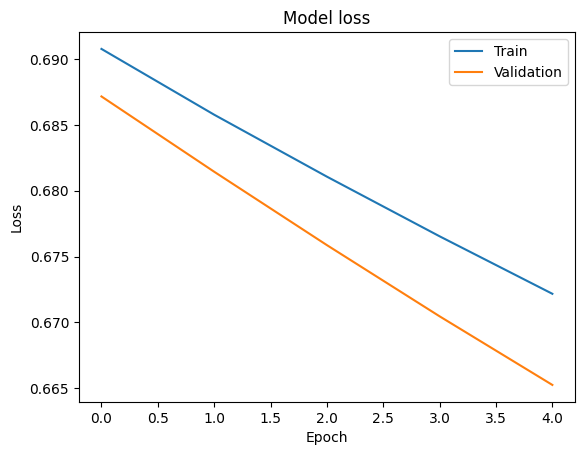

In [11]:

# Plot training results
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

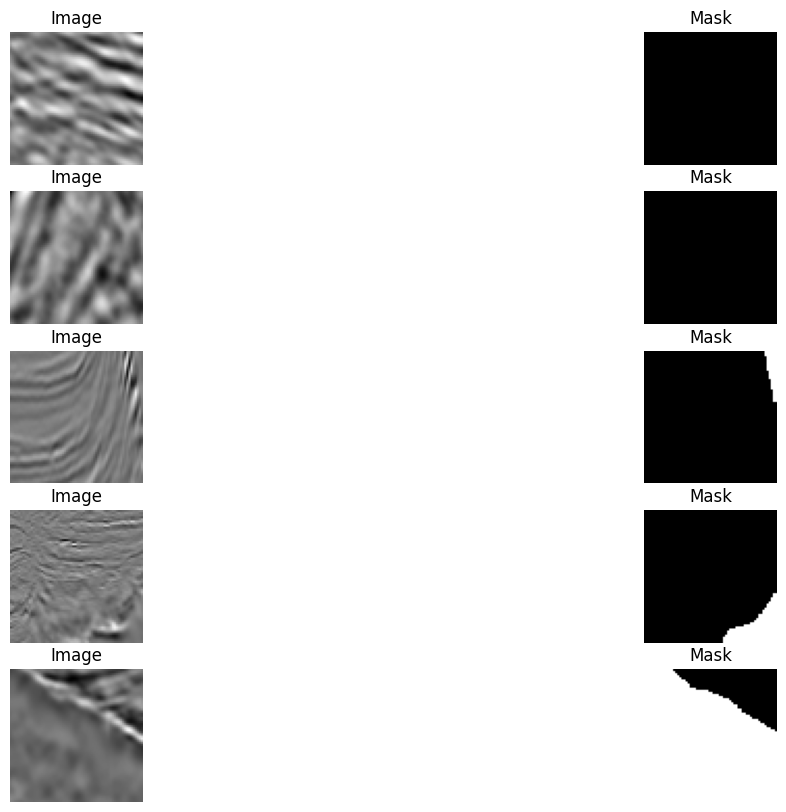

In [12]:
import matplotlib.pyplot as plt

def plot_images(images, masks, num_images=5):
    """
    Plot images and their corresponding masks.
    """
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
    
    plt.show()

# Plot some images and masks
plot_images(X_val, Y_val)
